In [1]:
import tensorflow as tf
import pickle
import tensorflow.keras as keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.layers.experimental import preprocessing
#from keras import backend as K
import numpy as np
#import pandas as pd
import sys
import os
import time
import math
sys.path.append(os.path.abspath('../'))
import helpers
import helpers.data_generator
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
# from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
# from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
#from utils.callbacks import CyclicLR, TensorBoardWrapper
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import r2_score
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import linear_model

2021-07-17 17:20:29.793950: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.2
2021-07-17 17:20:30.571630: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.7
2021-07-17 17:20:30.572341: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.7


In [2]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8

# Load model and process data

In [3]:
"""THIS IS THE ONE FROM THE PAPER AS OF 3/5"""
import h5py
import shutil
import numpy as np
import sys

file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'

base_path = os.path.expanduser('/projects/EKOLEMEN/profile_predictor/run_results_03_10/')
"""good but overfit"""
#model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_01Mar20-19-50_Scenario-93.h5'
"""good val but looks bad?"""
# model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_01Mar20-02-31_Scenario-71.h5'

model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5'
file_path = base_path + model_path

# convert_h5py(file_path)

model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

2021-07-17 17:20:33.391655: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-17 17:20:33.516077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1558] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: NVIDIA Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.50GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-17 17:20:33.518047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1558] Found device 1 with properties: 
pciBusID: 0035:03:00.0 name: NVIDIA Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.50GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-17 17:20:33.518065: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.2
2021-07-17 17:20:33.518099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library

loaded model: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5
loaded dict: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl
with parameters: dict_keys(['model_type', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'sample_weightin', 'scalar_input_names', 'std_activation', 'batch_size', 'process_data', 'predict_deltas', 'epochs', 'loss_function', 'actuator_names', 'profile_downsample', 'sample_weighting', 'loss_function_kwargs', 'flattop_only', 'raw_data_path', 'invert_q', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'val_idx', 'nshots', 'excluded_shots', 'lookbac

In [4]:
orig_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(orig_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      invert_q=scenario.setdefault('invert_q',False),
                                                      val_idx = 0)

traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])
valdata = helpers.normalization.renormalize(helpers.normalization.denormalize(valdata.copy(),normalization_dict),scenario['normalization_dict'])


Loading
Signals: curr_target, dens, density_estimate, kappa_EFIT01, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  6378
Number of shots used:  6378
Total number of timesteps:  671222
Shots with Complete NaN: 
454582 samples total
Removing ECH
Removed 194246 samples
260336 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 52091 samples
208245 samples remaining
Removing weird I-coils
Removed 46528 samples
161717 samples remaining
Removing NaN
Removed 0 samples
161717 samples remaining
Removing dudtrip
Removed 9571 samples
152146 samples remaining
152146 samples remaining after pruning
Total number of samples:  152146
Number of training samples:  137014
Number of validation samples:  15132


Normalizing: 100%|#########################################################################################################################################################| 24/24 [00:00<00:00, 95.69it/s]


### Note here that we are really training on the validation set, could possibly get better results using the full dataset (about 10x more samples)

In [5]:
realtraindata = traindata.copy()
realvaldata = valdata.copy()

In [6]:
traindata = valdata

In [7]:
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std') #scenario['shuffle_generators'])

In [8]:
traindatafull = copy.deepcopy(traindata)
train_generator_batch = DataGenerator(traindatafull,
                                128, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                #all_profiles,
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                #all_profiles,
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None) #scenario['shuffle_generators'])

# Generate predictions from original model

In [9]:
inputs = {sig:[] for sig in scenario['target_profile_names']}
baseline = {sig:[] for sig in scenario['target_profile_names']}
predictions = {sig:[] for sig in scenario['target_profile_names']}
for i in range(len(train_generator_batch)):
    print(i,end=',')
    sample = train_generator_batch[i]
    out = model.predict(sample[0])
    for k, sig in enumerate(scenario['target_profile_names']):
        inputs[sig].append(sample[0]["input_"+sig][:,0,:])
        if scenario['predict_deltas']:
            baseline[sig].append(sample[1]['target_'+sig])
            predictions[sig].append(out[k])
        else:
            baseline[sig].append(sample[1]['target_'+sig].squeeze() - sample[0]['input_'+sig].squeeze())
            predictions[sig].append(out[k].squeeze() - sample[0]['input_'+sig].squeeze())
inputs = {sig:np.concatenate(inputs[sig],axis=0) for sig in scenario['target_profile_names']}
baseline = {sig:np.concatenate(baseline[sig],axis=0) for sig in scenario['target_profile_names']}
predictions = {sig:np.concatenate(predictions[sig],axis=0) for sig in scenario['target_profile_names']}
model_err = {sig: (predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}
model_err_abs = {sig: np.abs(predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}

0,

2021-07-17 17:24:39.611265: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-17 17:24:39.780454: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,

# Compute PCA modes/coeffs for input profiles, errors etc

In [10]:
num_components=5
full_pca_fitters = {}
full_profiles = {}

for profile in scenario['target_profile_names']:
    full = inputs[profile]
    full_profiles[profile] = full
    full_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full)
    print(profile, ' done full')

dens  done full
temp  done full
q_EFIT01  done full
rotation  done full
press_EFIT01  done full


In [11]:
num_components=5
full_pca_fitter_errs = {}
full_pca_fitter_errs_abs = {}
profiles=scenario['target_profile_names']

#delta_pca_fitters = {}

for profile in scenario['target_profile_names']:
    full_err = model_err[profile]
    full_err_abs = model_err_abs[profile]
    full_pca_fitter_errs[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full_err)
    print(profile, ' done err')
    full_pca_fitter_errs_abs[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full_err_abs)
    print(profile, ' done abs err')


dens  done err
dens  done abs err
temp  done err
temp  done abs err
q_EFIT01  done err
q_EFIT01  done abs err
rotation  done err
rotation  done abs err
press_EFIT01  done err
press_EFIT01  done abs err


In [12]:
'''coefficients of PCA decomposition'''

coeff_og = {}
coeff_err = {}
coeff_err_abs = {}
for profile in profiles:
    coeff_og[profile] = decomposition.IncrementalPCA(n_components=5).fit_transform(inputs[profile])
    coeff_err[profile] = decomposition.IncrementalPCA(n_components=5).fit_transform(model_err[profile])
    coeff_err_abs[profile] = decomposition.IncrementalPCA(n_components=5).fit_transform(model_err_abs[profile])

In [13]:
'''chop off last three pca modes of the pressure profile'''
#coeff_og = np.concatenate((coeff_og[profiles[0]], coeff_og[profiles[1]], coeff_og[profiles[2]], coeff_og[profiles[3]], coeff_og[profiles[4]][:, 0:2]), axis=1)
coeff_og_sliced = coeff_og.copy()
coeff_og_sliced['press_EFIT01'] = coeff_og['press_EFIT01'][:, 0:2]
coeff_err_sliced = coeff_err.copy()
coeff_err_sliced['press_EFIT01'] = coeff_err['press_EFIT01'][:, 0:2]
#print(coeff_og['press_EFIT01'])
print(len(coeff_og['press_EFIT01']))
print(len(coeff_og['press_EFIT01'][0]))
print(len(coeff_og['temp']))
print(len(coeff_og['temp'][0]))
print(len(coeff_og_sliced['press_EFIT01']))
print(len(coeff_og_sliced['press_EFIT01'][0]))
print(len(coeff_og_sliced['temp']))
print(len(coeff_og_sliced['temp'][0]))

15132
5
15132
5
15132
2
15132
5


# Get some baseline values for MAE/MSE before any corrections

In [14]:
model_mae = {}
model_mse = {}
for profile in profiles:
    model_mae[profile] = np.mean(abs(model_err[profile]))
    model_mse[profile] = np.mean(model_err[profile]**2)
    print(profile)
    print("Mean abs error: ", model_mae[profile])
    print("Mean squared error: ", model_mse[profile])
    print("")


dens
Mean abs error:  0.0735865
Mean squared error:  0.016929187

temp
Mean abs error:  0.046572004
Mean squared error:  0.00687674

q_EFIT01
Mean abs error:  0.030760651
Mean squared error:  0.0043095234

rotation
Mean abs error:  0.0818738
Mean squared error:  0.029361911

press_EFIT01
Mean abs error:  0.04789626
Mean squared error:  0.009897972



# Cross Validated Ridge regression with PCA coeffs

In [15]:
"""Note setting cv=10 does k-fold cross validation with k=10, otherwise it does leave one out which can give a worse estimate of the true variation"""
res_og = np.hstack([foo for foo in coeff_og_sliced.values()])
res_err = np.hstack([foo for foo in coeff_err_sliced.values()])


ridge_err_pca = {profile: [] for profile in profiles}
ridge_mse_pca = {profile: [] for profile in profiles}
ridge_mae_pca = {profile: [] for profile in profiles}
alphas = [1e-2, 1e-1, 1, 10, 100, 1000, 10000]

for alpha in alphas:
    ridge = linear_model.RidgeCV(cv=10, alphas=[alpha])
    ridge.fit(res_og, res_err)
    lin_err_ridge = ridge.predict(res_og)
    for i in range(5):
        correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
        ridge_err_pca[profiles[i]].append(model_err[profiles[i]] - correction_ridge)
        ridge_mae_pca[profiles[i]].append(np.mean(np.abs(ridge_err_pca[profiles[i]][-1])))
        ridge_mse_pca[profiles[i]].append(np.mean(np.square(ridge_err_pca[profiles[i]][-1])))
    

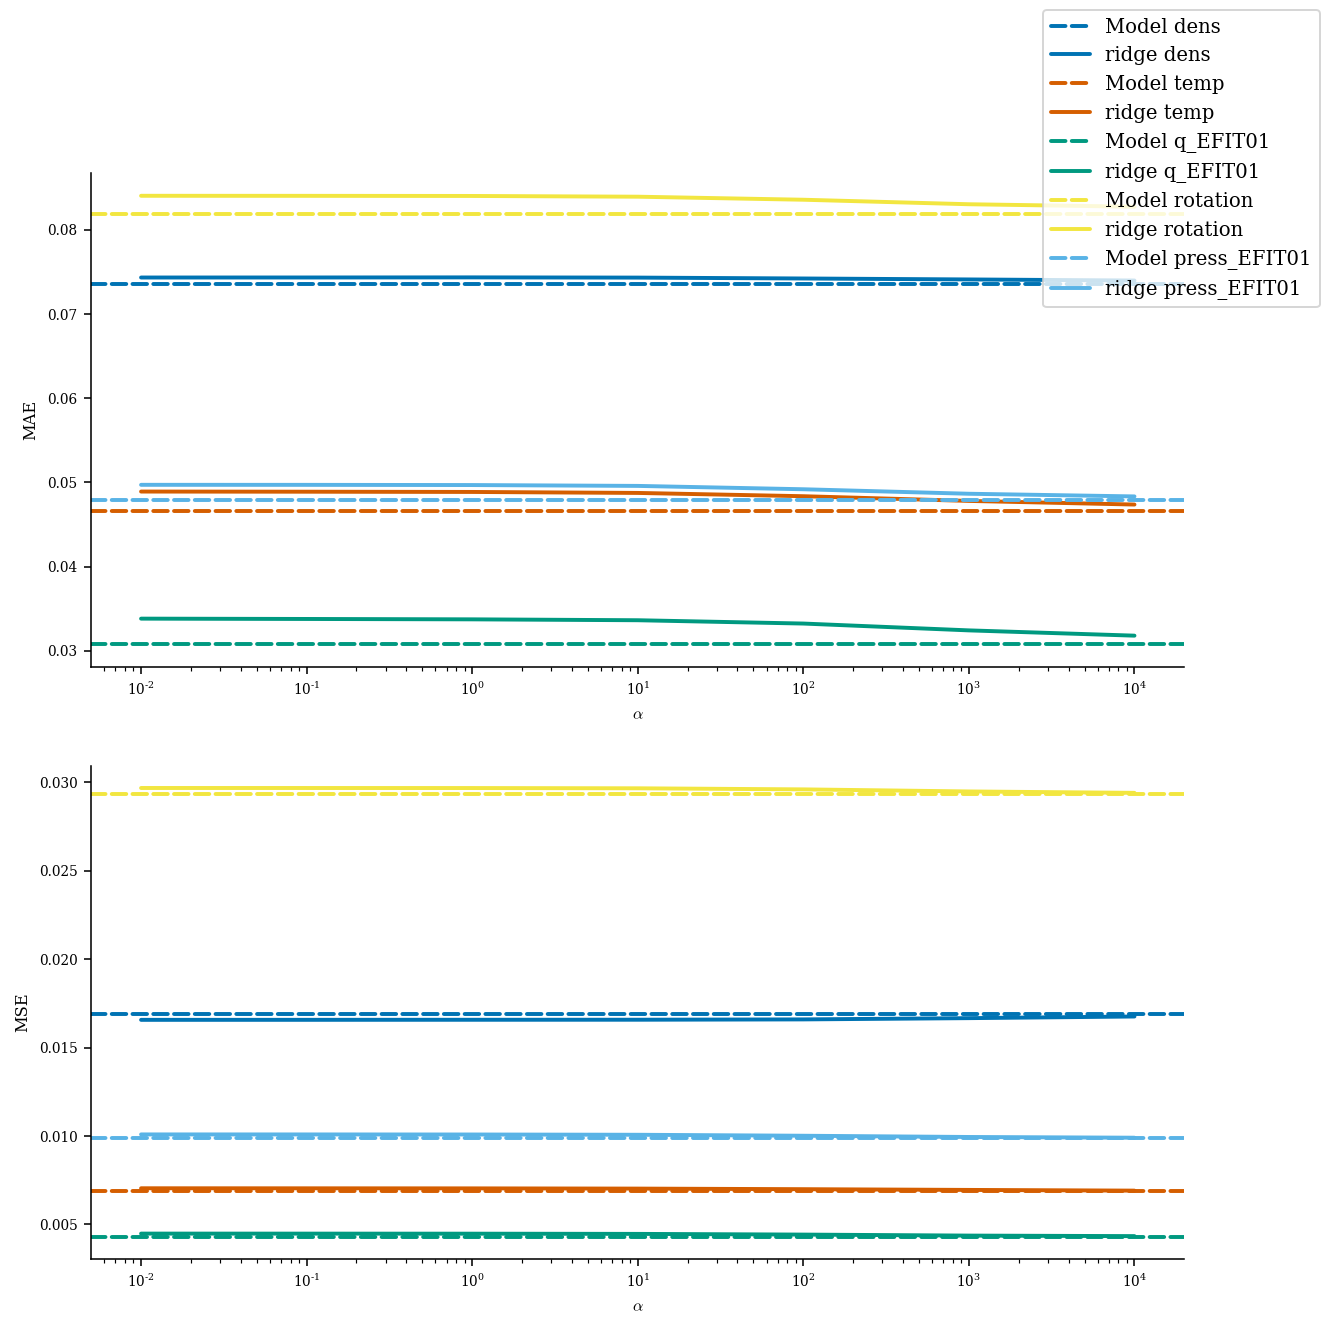

In [17]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

for i, profile in enumerate(profiles):
    ax[0].axhline(model_mae[profile], ls="--", c=colorblind_colors[i], label="Model " + profile)
    ax[0].semilogx(alphas, ridge_mae_pca[profile], c=colorblind_colors[i], label="ridge " + profile)    
    ax[0].set_ylabel("MAE")
    ax[0].set_xlabel("$\\alpha$")
    ax[1].axhline(model_mse[profile], ls="--", c=colorblind_colors[i])
    ax[1].semilogx(alphas, ridge_mse_pca[profile], c=colorblind_colors[i])    
    ax[1].set_ylabel("MSE")
    ax[1].set_xlabel("$\\alpha$")
fig.legend()

### Seems like ridge with pca modes generally does worse than the uncorrected model

# Ridge with raw (full) profiles

In [18]:
res_og = np.hstack([foo for foo in inputs.values()])
res_err = np.hstack([foo for foo in model_err.values()])

ridge_err_full = {profile: [] for profile in profiles}
ridge_mse_full = {profile: [] for profile in profiles}
ridge_mae_full = {profile: [] for profile in profiles}
alphas = [1e-2, 1e-1, 1, 10, 100, 1000, 10000]

for alpha in alphas:
    ridge = linear_model.RidgeCV(cv=10, alphas=[alpha])
    ridge.fit(res_og, res_err)
    lin_err_ridge = ridge.predict(res_og)
    for i in range(5):
        correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
        ridge_err_full[profiles[i]].append(model_err[profiles[i]] - correction_ridge)
        ridge_mae_full[profiles[i]].append(np.mean(np.abs(ridge_err_full[profiles[i]][-1])))
        ridge_mse_full[profiles[i]].append(np.mean(np.square(ridge_err_full[profiles[i]][-1])))
    

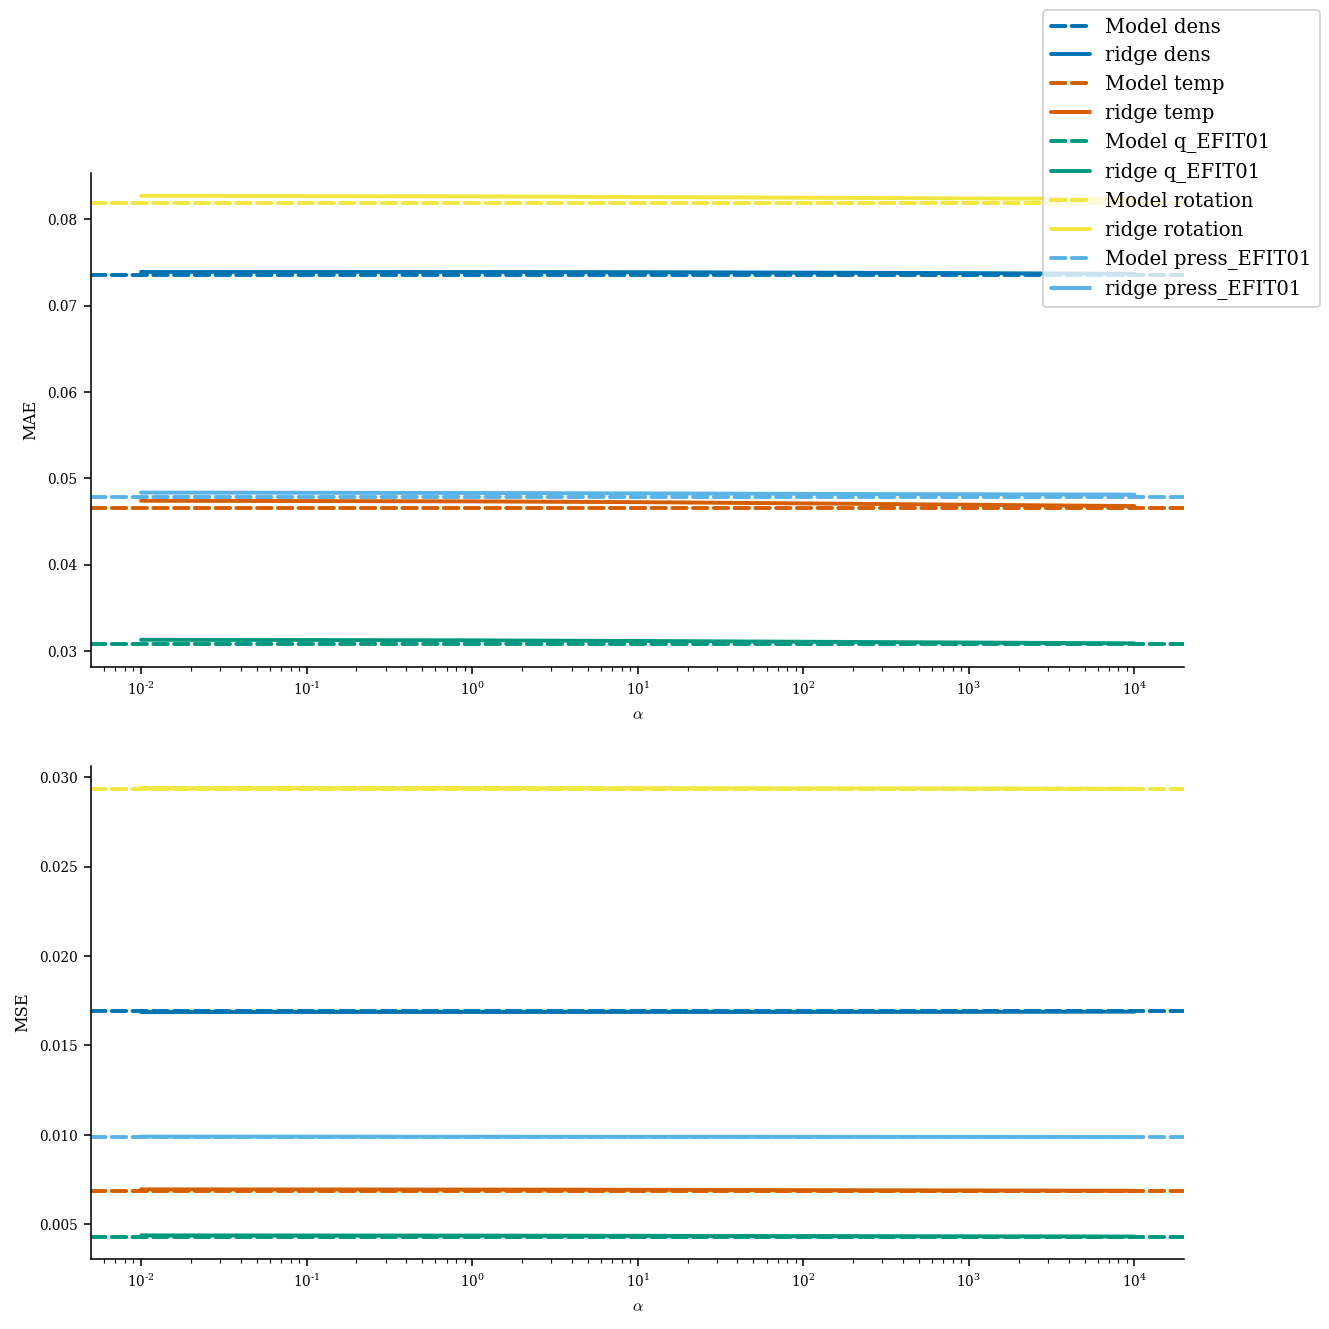

In [20]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

for i, profile in enumerate(profiles):
    ax[0].axhline(model_mae[profile], ls="--", c=colorblind_colors[i], label="Model " + profile)
    ax[0].semilogx(alphas, ridge_mae_full[profile], c=colorblind_colors[i], label="ridge " + profile)    
    ax[0].set_ylabel("MAE")
    ax[0].set_xlabel("$\\alpha$")
    ax[1].axhline(model_mse[profile], ls="--", c=colorblind_colors[i], )
    ax[1].semilogx(alphas, ridge_mse_full[profile], c=colorblind_colors[i], )    
    ax[1].set_ylabel("MSE")
    ax[1].set_xlabel("$\\alpha$")
fig.legend()

### Better than using PCA but still mostly worse than baseline

# Try ridge without CV, manually set alpha=1000

In [21]:
ridge_errs = {}
res_og = np.hstack([foo for foo in coeff_og_sliced.values()])
res_err = np.hstack([foo for foo in coeff_err_sliced.values()])

ridge2 = linear_model.Ridge(alpha=1000)
ridge2.fit(res_og, res_err)
lin_err_ridge = ridge2.predict(res_og)
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs[profiles[i]])))
    print("Mean error: " + str(np.mean(ridge_errs[profiles[i]])))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs[profiles[i]]))))
    print("Mean abs error: " + str(np.mean(abs(ridge_errs[profiles[i]]))))
    print("Mean squared error: " + str(np.mean(np.square(ridge_errs[profiles[i]]))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs[profile])

545.5594781168514
Sum of errors for dens: 2.6432189770275727e-12
Mean error: 5.293255667354698e-18
Sum of abs errors for dens: 37004.228824615435
Mean abs error: 0.07410390347690912
Mean squared error: 0.016666861136142744

Sum of errors for temp: -4.298783551348606e-13
Mean error: -8.60865505040213e-19
Sum of abs errors for temp: 23870.75862986437
Mean abs error: 0.04780308763660469
Mean squared error: 0.006951204403343304

Sum of errors for q_EFIT01: 7.105427357601002e-14
Mean error: 1.4229181901491124e-19
Sum of abs errors for q_EFIT01: 16193.288307024448
Mean abs error: 0.03242834432153503
Mean squared error: 0.004367754891017205

Sum of errors for rotation: -1.6910917111090384e-12
Mean error: -3.3865452925548877e-18
Sum of abs errors for rotation: 41464.08410804778
Mean abs error: 0.08303511744736776
Mean squared error: 0.029489108651697182

Sum of errors for press_EFIT01: 1.1937117960769683e-12
Mean error: 2.390502559450509e-18
Sum of abs errors for press_EFIT01: 24295.5235320431

### These numbers seem in the same ballpark as the baseline, but not a major improvement in MSE or MAE, though signed error does go down a lot

# Plot median error and +/- 25 percentiles for ridge w/ alpha=1000 and no CV

In [22]:
hi_per = 75
low_per = 25

baseline_abs_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}
model_abs_err = {sig: np.abs(model_err[sig]) for sig in scenario["target_profile_names"]}
ridge_abs_err = {sig: np.abs(ridge_errs[sig]) for sig in scenario["target_profile_names"]}

med_model_err = {sig:np.median(np.abs(model_abs_err[sig])*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_ridge_err = {sig:np.median(np.abs(ridge_abs_err[sig])*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(model_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_ridge_hiper = {sig:np.percentile(ridge_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(model_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_ridge_lowper = {sig:np.percentile(ridge_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

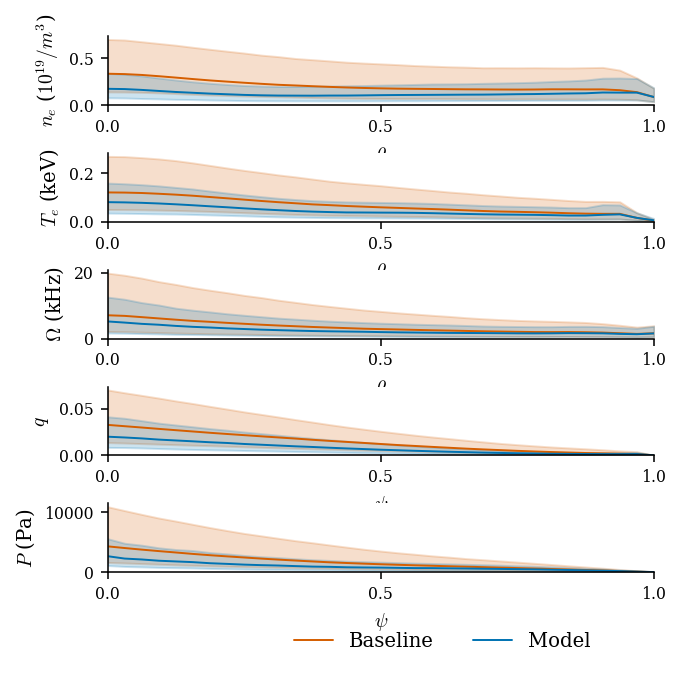

In [23]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)

fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig], lw=1, c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],lw=1, c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

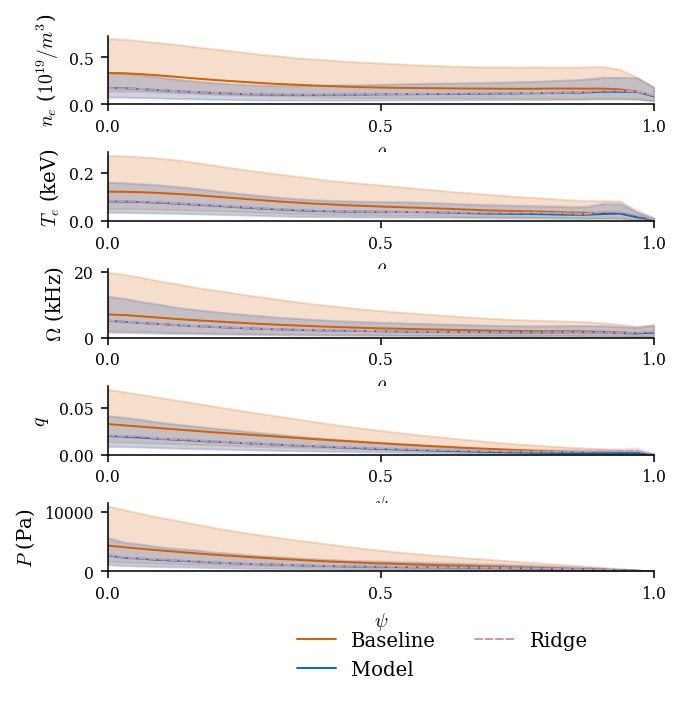

In [24]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)

fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],lw=1, c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],lw=1, c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    
    ax[i].plot(psi,med_ridge_err[sig],lw=1, ls="--", c=colorblind_colors[5],label='Ridge')
    ax[i].fill_between(psi,med_ridge_lowper[sig],med_ridge_hiper[sig],color=colorblind_colors[5],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

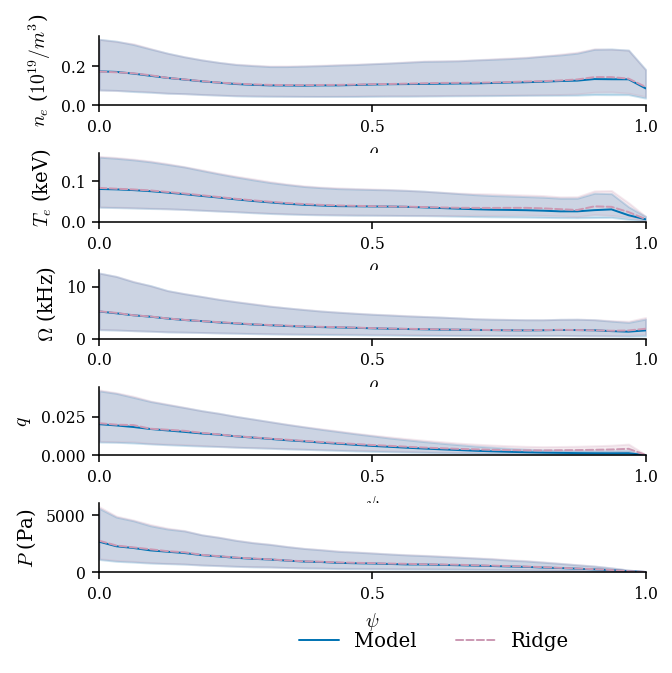

In [25]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)

fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_model_err[sig],lw=1, c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    
    ax[i].plot(psi,med_ridge_err[sig],lw=1, ls="--", c=colorblind_colors[5],label='Ridge')
    ax[i].fill_between(psi,med_ridge_lowper[sig],med_ridge_hiper[sig],color=colorblind_colors[5],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

# Generalized Tikhonov Regularization

In [63]:
"""Compute covariance matrices"""

model_err_arr = np.hstack([model_err[sig] for sig in profiles])
model_inp_arr = np.hstack([inputs[sig] for sig in profiles])

model_err_cov = np.cov(model_err_arr)
model_inp_cov = np.cov(model_inp_arr, rowvar=False)
inp_err_cov = np.cov(model_err_arr, model_inp_arr, rowvar=False)[33*5:,0:33*5]
inp_err_cov = inp_err_cov.T @ inp_err_cov


In [77]:
"""Scan over weighting factors for Q - sort of combining tikhonov + ridge"""

tiknv_correction = {profile:[] for profile in profiles} 
tiknv_err = {profile:[] for profile in profiles} 
tiknv_mae = {profile:[] for profile in profiles} 
tiknv_mse = {profile:[] for profile in profiles} 

alphas = np.logspace(-4,2,20)
for alpha in alphas:
    A = model_inp_arr
    b = model_err_arr
    Q = alpha * np.linalg.pinv(inp_err_cov, rcond=1e-10)
    P = np.diag(1/np.sqrt(np.sum(model_err_cov**2, axis=0)))
    x = np.linalg.solve(A.T @ P @ A + Q, A.T @ P @ b)

    _tik_correction = model_inp_arr @ x
    for i, profile in enumerate(profiles):
        tiknv_correction[profile].append(_tik_correction[:,i*33:(i+1)*33])
        tiknv_err[profile].append(model_err[profile] - tiknv_correction[profile][-1])
        tiknv_mae[profile].append(np.mean(np.abs(tiknv_err[profile][-1])))
        tiknv_mse[profile].append(np.mean(tiknv_err[profile][-1]**2))        

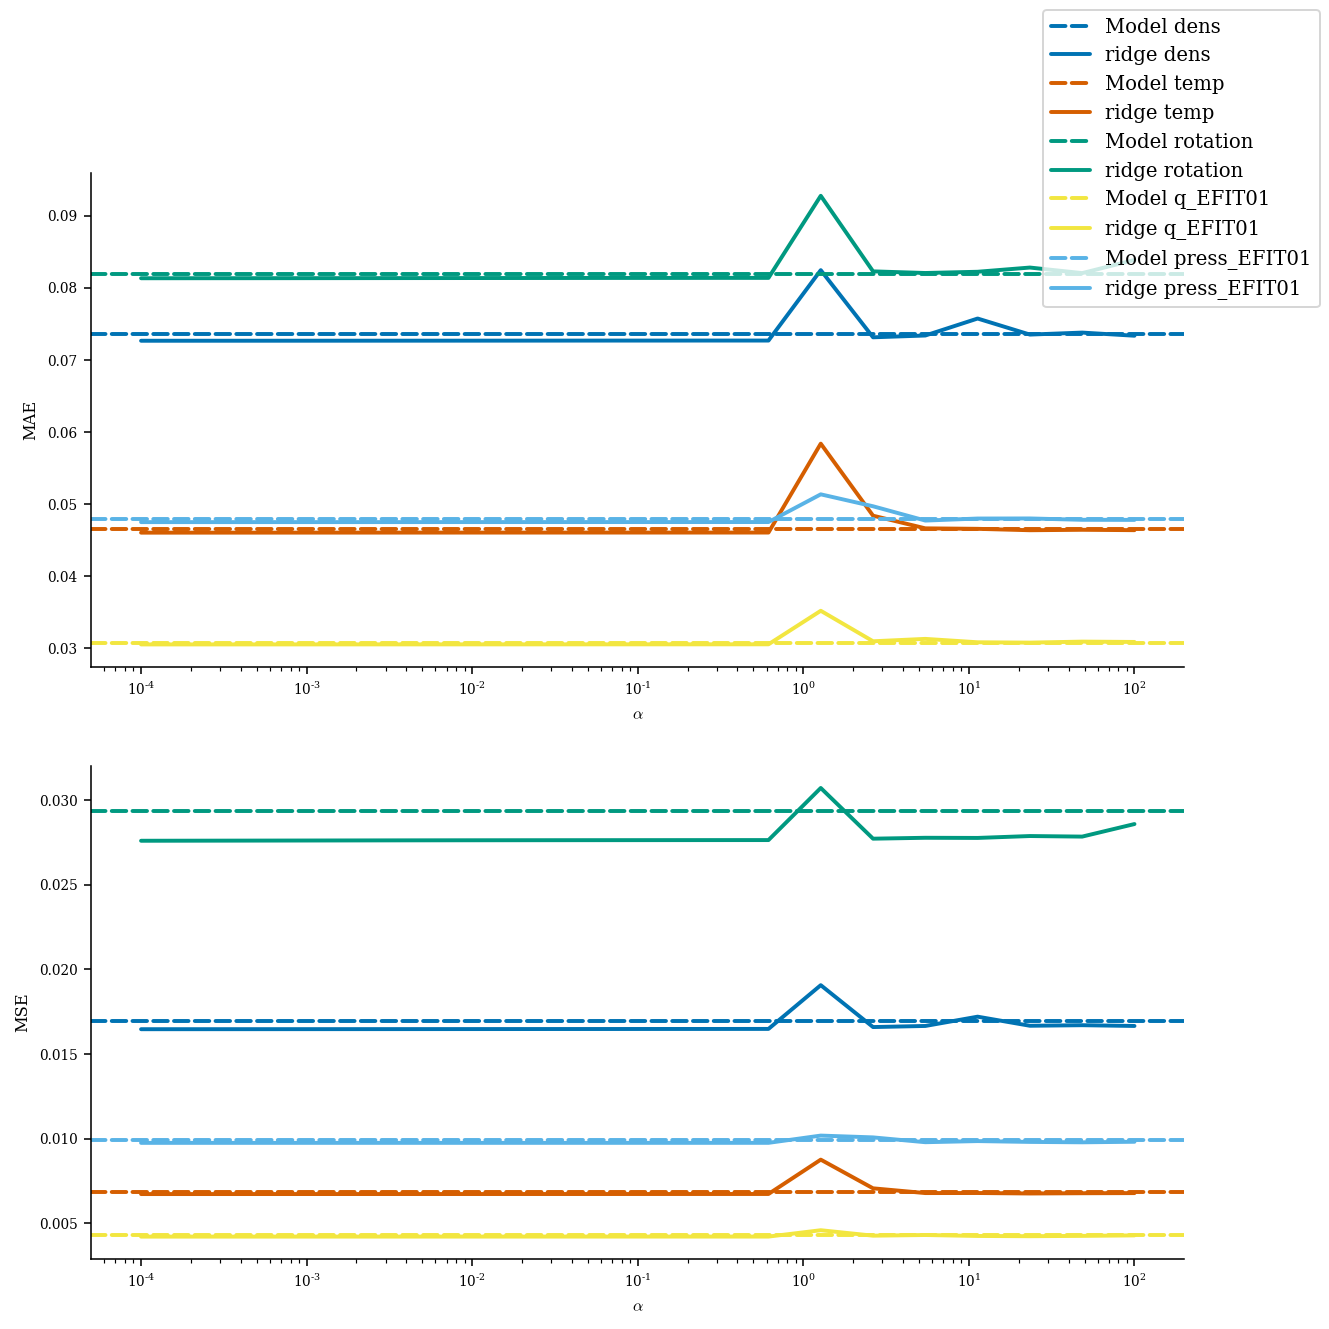

In [78]:
"""Plot results of scan over alpha"""

fig, ax = plt.subplots(2,1, figsize=(10,10))

for i, profile in enumerate(profiles):
    ax[0].axhline(model_mae[profile], ls="--", c=colorblind_colors[i], label="Model " + profile)
    ax[0].semilogx(alphas, tiknv_mae[profile], c=colorblind_colors[i], label="ridge " + profile)    
    ax[0].set_ylabel("MAE")
    ax[0].set_xlabel("$\\alpha$")
    ax[1].axhline(model_mse[profile], ls="--", c=colorblind_colors[i], )
    ax[1].semilogx(alphas, tiknv_mse[profile], c=colorblind_colors[i], )    
    ax[1].set_ylabel("MSE")
    ax[1].set_xlabel("$\\alpha$")
fig.legend()

### Some decent improvement on several profiles, seems like lower alpha tends to do better

In [79]:

hi_per = 75
low_per = 25
good_alpha_idx = 2


baseline_abs_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}
model_abs_err = {sig: np.abs(model_err[sig]) for sig in scenario["target_profile_names"]}
tiknv_abs_err = {sig: np.abs(tiknv_err[sig][good_alpha_idx]) for sig in scenario["target_profile_names"]}

med_model_err = {sig:np.median(np.abs(model_abs_err[sig])*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_tiknv_err = {sig:np.median(np.abs(tiknv_abs_err[sig])*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(model_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_tiknv_hiper = {sig:np.percentile(tiknv_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(model_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_tiknv_lowper = {sig:np.percentile(tiknv_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_abs_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}



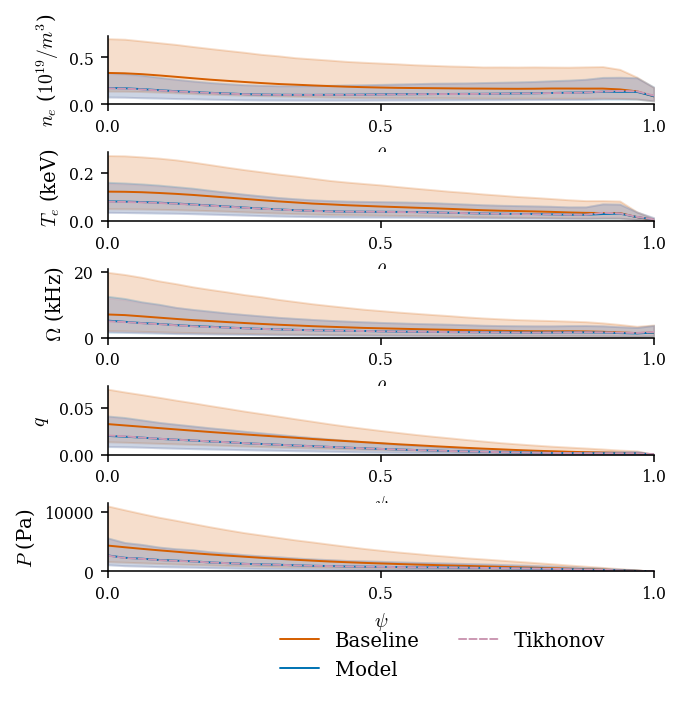

In [80]:
"""Shaded plot for baseline, regular model, model + tikhonov"""

labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)

fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],lw=1, c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],lw=1, c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    
    ax[i].plot(psi,med_tiknv_err[sig],lw=1, ls="--", c=colorblind_colors[5],label='Tikhonov')
    ax[i].fill_between(psi,med_tiknv_lowper[sig],med_tiknv_hiper[sig],color=colorblind_colors[5],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

### Hard to see a major differnece, though the previous plots seemed to show a reduction in MAE and MSE

/home/wconlin/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x20072bdeec90> has a label of '_line1' which cannot be automatically added to the legend.


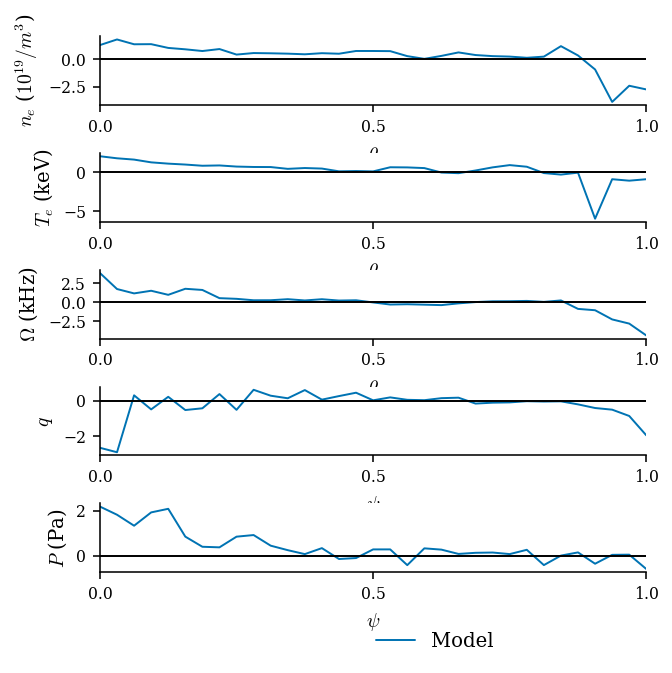

In [88]:
"""Plot the percent impovement after tikhonov correction. Positive = more accurate, negative = less accurate"""

labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)

fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    pct_err = 100*(med_model_err[sig] - med_tiknv_err[sig]) / np.mean(abs(med_model_err[sig]) + abs(med_tiknv_err[sig]))
    ax[i].plot(psi,pct_err,lw=1, c=colorblind_colors[0],label='Model')
    ax[i].axhline(0, c="k", lw=1)

    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)